### Section 1: Problem Statement/ Business Understanding:

In the real estate industry, determining the sale price of a house is a crucial task for both the buyer and the seller. The sale price of a house depends on various factors such as its location, age, size, and the number of rooms, among others. The objective of this project is to analyze the house features and find the most correlated features with the sale price. Furthermore, the project also covers the use of machine learning models to predict the sale price of a house based on the given features.

The data used in this project is obtained from a Kaggle competition and includes information on various features of the house, such as its location, age, size, and the number of rooms, among others. The target variable is the sale price of the house.

#### The questions that this project aims to answer are:

- What are the most correlated features in a house with the sale price?
- What year were most of the houses built and does it have any correlation with the sale price? Is there variation in the sale price based on the month?
- Can we use machine learning models to predict the sale price of a house with good accuracy?

The solution to this problem will provide valuable insights for both buyers and sellers in the real estate industry by providing them with a better understanding of the factors that determine the sale price of a house. Additionally, the machine learning model developed in this project can be used to predict the sale price of a house based on its features, thus helping buyers and sellers to make informed decisions.

#### CRISP-DM process consists of six phases, as follows, which we will be utiziling:

- Business Understanding: In this phase, the objective of the project and the business problem to be solved are defined. The data mining goals and success criteria are also established in this phase.

- Data Understanding: In this phase, the data is collected and explored to gain an understanding of its quality, completeness, and structure. This phase includes tasks such as data exploration, data quality assessment, and data cleaning.

- Data Preparation: In this phase, the data is transformed and cleaned so that it is in a format that can be used for analysis. This phase includes tasks such as missing value imputation, feature scaling, and data normalization.

- Modeling: In this phase, statistical and machine learning models are developed to analyze the data and solve the business problem. This phase includes tasks such as model selection, feature selection, and model evaluation.

- Evaluation: In this phase, the results of the models are evaluated to determine their performance and accuracy. This phase includes tasks such as performance measurement, model comparison, and model tuning.

- Deployment: In this phase, the model is deployed to the production environment and put into use. This phase includes tasks such as model deployment, monitoring, and maintenance.

In [51]:
# Import Libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split,cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler,OrdinalEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression,Lasso,Ridge,BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
#from lightgbm import LGBMRegressor

import math
from IPython.display import Image
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline
sns.set(rc={"figure.figsize": (20, 15)})
sns.set_style("whitegrid")

### Section 2: Data Understanding/Data Exploration

####  Gather Data

In [52]:
# Read Files
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")
submission = pd.read_csv("data/sample_submission.csv")
df = pd.concat([df_train,df_test],axis = 0,ignore_index = True)

In [53]:
# Open the text file that contains the description of various variables. 
# Create a dictionary that takes in the key as column name and gives out description
# Create a dictionary to see the description of the column names
with open("data/data_description.txt","r") as f:
        texts = f.readlines()

newlist = list()
for col in df.columns:
    for text in texts:
        if col in text:
            newlist.append(text.split(":"))
            
desc = dict()
for item in newlist:
    if len(item)==2:
        desc[item[0]] = item[1]

## Example     
print(desc["YearRemodAdd"])
print(desc["LandSlope"])
print(desc["MoSold"])

 Remodel date (same as construction date if no remodeling or additions)

 Slope of property

 Month Sold (MM)



In [54]:
df_train.head(5).style.background_gradient(cmap = "viridis")

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000000,8450,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,nan,Attchd,2003.000000,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,nan,nan,nan,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000000,9600,Pave,nan,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,nan,nan,nan,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000000,11250,Pave,nan,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.000000,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,nan,nan,nan,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000000,9550,Pave,nan,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.000000,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,nan,nan,nan,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000000,14260,Pave,nan,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.000000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,nan,nan,nan,0,12,2008,WD,Normal,250000


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

In [56]:
df.describe().transpose().style.background_gradient(cmap = "magma")

,count,mean,std,min,25%,50%,75%,max
Id,2919.000000,1460.000000,842.787043,1.000000,730.500000,1460.000000,2189.500000,2919.000000
MSSubClass,2919.000000,57.137718,42.517628,20.000000,20.000000,50.000000,70.000000,190.000000
LotFrontage,2433.000000,69.305795,23.344905,21.000000,59.000000,68.000000,80.000000,313.000000
LotArea,2919.000000,10168.114080,7886.996359,1300.000000,7478.000000,9453.000000,11570.000000,215245.000000
OverallQual,2919.000000,6.089072,1.409947,1.000000,5.000000,6.000000,7.000000,10.000000
OverallCond,2919.000000,5.564577,1.113131,1.000000,5.000000,5.000000,6.000000,9.000000
YearBuilt,2919.000000,1971.312778,30.291442,1872.000000,1953.500000,1973.000000,2001.000000,2010.000000
YearRemodAdd,2919.000000,1984.264474,20.894344,1950.000000,1965.000000,1993.000000,2004.000000,2010.000000
MasVnrArea,2896.000000,102.201312,179.334253,0.000000,0.000000,0.000000,164.000000,1600.000000
BsmtFinSF1,2918.000000,441.423235,455.610826,0.000000,0.000000,368.500000,733.000000,5644.000000


In [57]:
print(df_train.shape)
print(df_test.shape) # the SalePrice column is missing in test data, which we need to predict.

(1460, 81)
(1459, 80)


#### Visualization

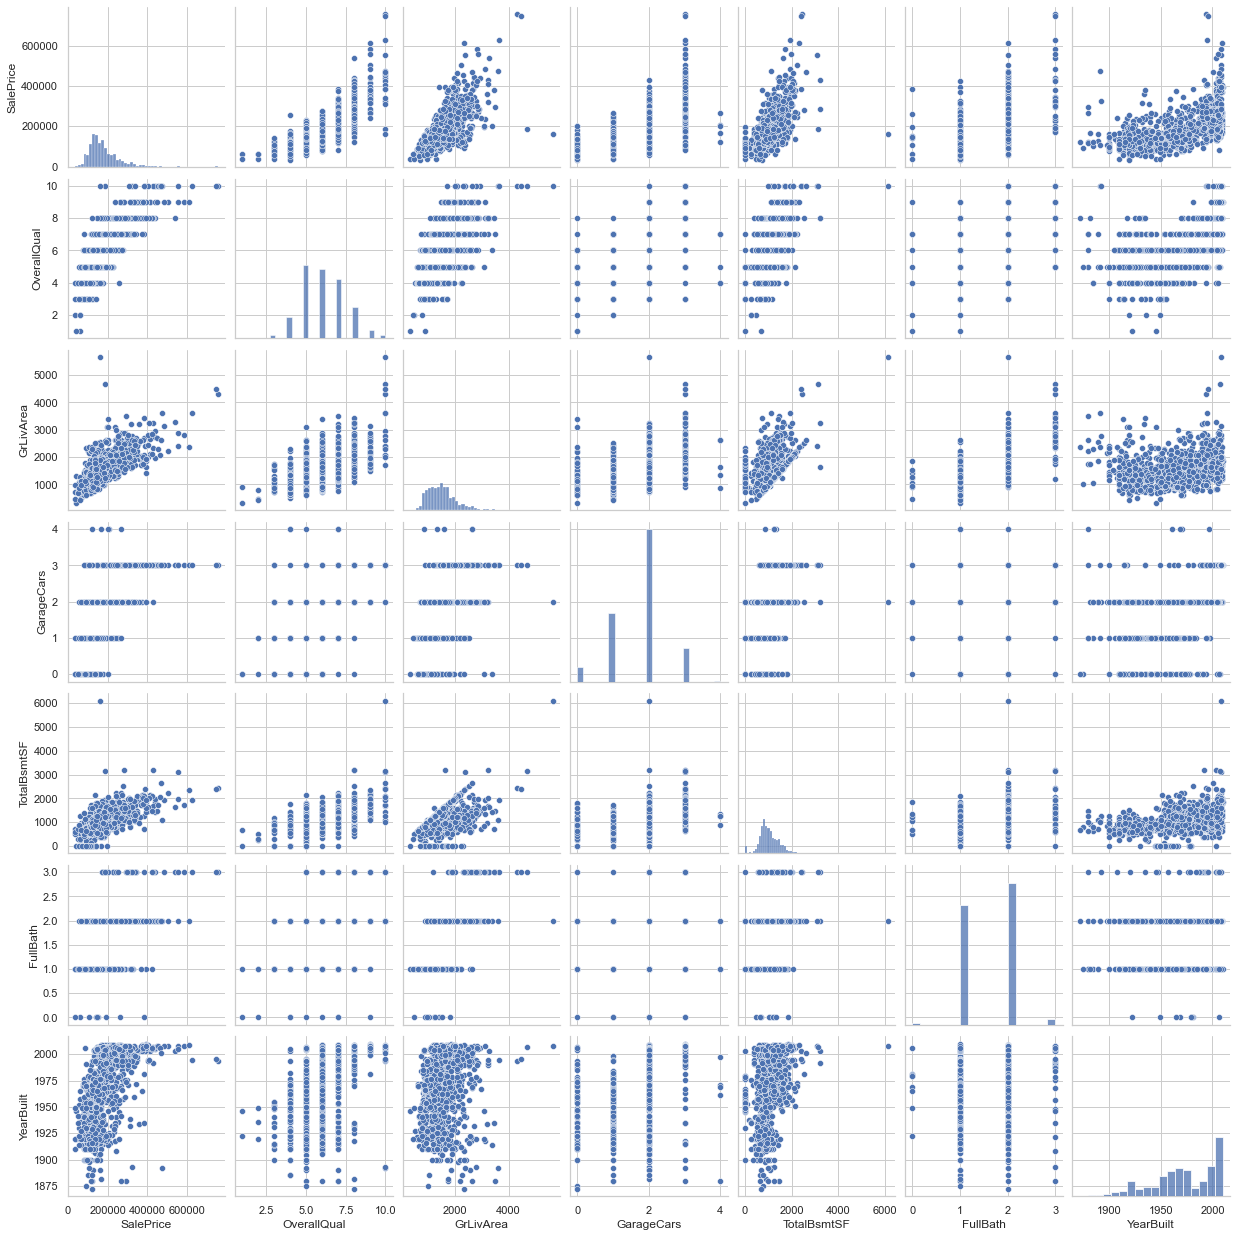

In [58]:
var_num = ["SalePrice", "OverallQual", "GrLivArea", "GarageCars", "TotalBsmtSF", "FullBath", "YearBuilt"]
sns.pairplot(df_train[var_num]);

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

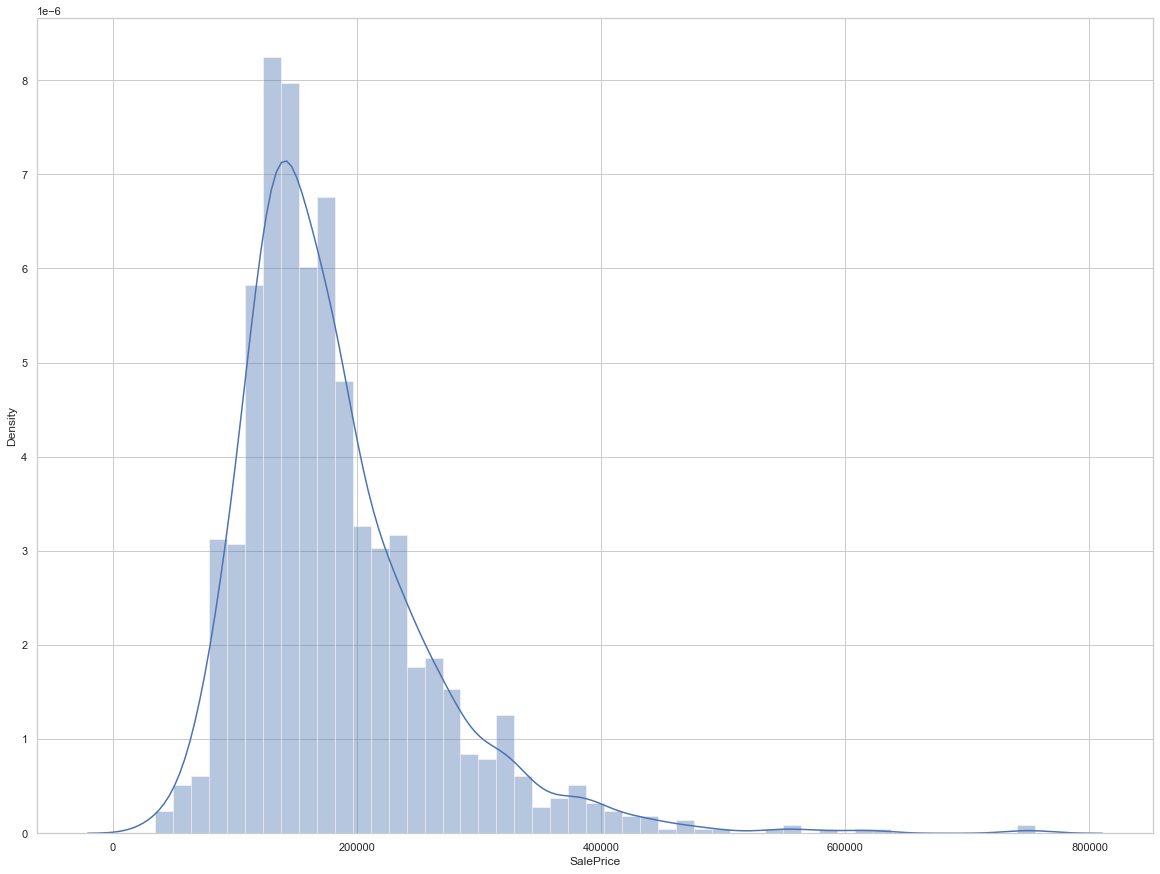

In [59]:
#Visualize dependent variable (SalePrice)
sns.distplot(df["SalePrice"])

In [60]:
# We can see that the distribution is postivitely skewed.
df["SalePrice"].describe()  ##There is a huge difference between the min and max..

count     1,460.00
mean    180,921.20
std      79,442.50
min      34,900.00
25%     129,975.00
50%     163,000.00
75%     214,000.00
max     755,000.00
Name: SalePrice, dtype: float64

<AxesSubplot:xlabel='LogSalePrice', ylabel='Density'>

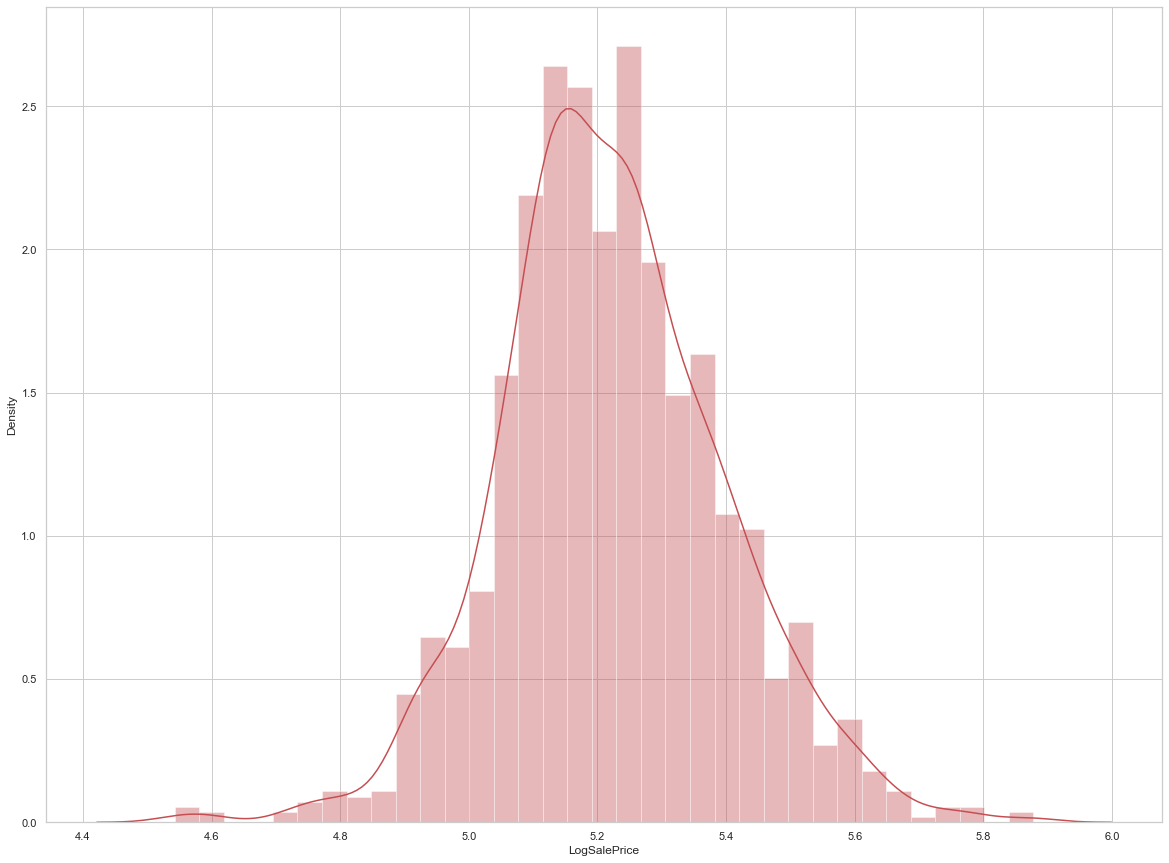

In [61]:
df["LogSalePrice"] = np.log10(df["SalePrice"])
sns.distplot(df["LogSalePrice"],color = 'r')

Since, the target variable is positively skewed, we would like to transform the variable using log of the price, which gave us a normally distributed chart, which is better for machine learning prediction

### Section 3: Data Preparation

#### Dealing with Missing Values in categorical features

In [62]:
## Lets create a list of column names for categorical and numerical features

cate_feat = list(df.select_dtypes(include = [object]).columns)
num_feat = list(df.select_dtypes(include = [int,float]).columns)

print(cate_feat)
print('\n')
print(num_feat)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',

In [63]:
## Number of missing values 
df[cate_feat].isnull().sum()

MSZoning            4
Street              0
Alley            2721
LotShape            0
LandContour         0
Utilities           2
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
RoofStyle           0
RoofMatl            0
Exterior1st         1
Exterior2nd         1
MasVnrType         24
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           81
BsmtCond           82
BsmtExposure       82
BsmtFinType1       79
BsmtFinType2       80
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
KitchenQual         1
Functional          2
FireplaceQu      1420
GarageType        157
GarageFinish      159
GarageQual        159
GarageCond        159
PavedDrive          0
PoolQC           2909
Fence            2348
MiscFeature      2814
SaleType            1
SaleCondition       0
dtype: int64

In [64]:
## Number of missing values in numerical features
df[num_feat].isnull().sum()

Id                  0
MSSubClass          0
LotFrontage       486
LotArea             0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
MasVnrArea         23
BsmtFinSF1          1
BsmtFinSF2          1
BsmtUnfSF           1
TotalBsmtSF         1
1stFlrSF            0
2ndFlrSF            0
LowQualFinSF        0
GrLivArea           0
BsmtFullBath        2
BsmtHalfBath        2
FullBath            0
HalfBath            0
BedroomAbvGr        0
KitchenAbvGr        0
TotRmsAbvGrd        0
Fireplaces          0
GarageYrBlt       159
GarageCars          1
GarageArea          1
WoodDeckSF          0
OpenPorchSF         0
EnclosedPorch       0
3SsnPorch           0
ScreenPorch         0
PoolArea            0
MiscVal             0
MoSold              0
YrSold              0
SalePrice        1459
LogSalePrice     1459
dtype: int64

Since there is alot missing in lotfrontage, and is related to lotArea as seen below, we will use linear reg to fill in the missing values for LotFrontage

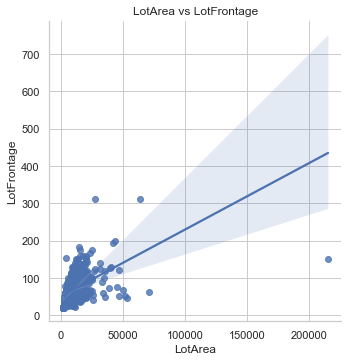

In [65]:
sns.lmplot(x="LotArea",y="LotFrontage",data = df)
plt.ylabel("LotFrontage")
plt.xlabel("LotArea")
plt.title("LotArea vs LotFrontage")
plt.show()

In [66]:
lm = LinearRegression()
lm_X = df[df['LotFrontage'].notnull()]['LotArea'].values.reshape(-1,1)
lm_y = df[df['LotFrontage'].notnull()]['LotFrontage'].values
lm.fit(lm_X,lm_y)
df['LotFrontage'].fillna((df['LotArea'] * lm.coef_[0] + lm.intercept_), inplace=True)
df['LotFrontage'] = df['LotFrontage'].apply(lambda x: int(x))

Since its only few values missing in each category, we dont need to explore alot. Just filling na values with median and mean

In [67]:
df["GarageYrBlt"].fillna(df["GarageYrBlt"].median(),inplace = True)
df["BsmtFinSF1"].fillna(df["BsmtFinSF1"].mean(),inplace = True)
df["BsmtFinSF2"].fillna(df["BsmtFinSF2"].mean(),inplace = True)
df["BsmtUnfSF"].fillna(df["BsmtUnfSF"].mean(),inplace = True)
df["TotalBsmtSF"].fillna(df["TotalBsmtSF"].mean(),inplace = True)
df["BsmtFullBath"].fillna(df["BsmtFullBath"].median(),inplace = True)
df["BsmtHalfBath"].fillna(df["BsmtHalfBath"].median(),inplace = True)
df["GarageArea"].fillna(df["GarageArea"].mean(),inplace = True)
df["GarageCars"].fillna(int(df["GarageCars"].median()),inplace = True)
df["MasVnrArea"].fillna(df["MasVnrArea"].median(),inplace = True)

#### Dealing with null values in Categorical features

In [68]:
## Since more than 90% of the column is null
df.drop(["Alley","FireplaceQu","PoolQC","MiscFeature"], axis = 1,inplace = True)
df.drop(["Fence"], axis = 1,inplace = True)

# Remove the items from the column list
for item in cate_feat:
    if item in ["Alley","FireplaceQu","PoolQC","MiscFeature"]:
        cate_feat.remove(item) 
cate_feat.remove("Fence")   

# Fill null values with none for items that are missing the item and mode for the rest of the missing values
cate_none = ["BsmtExposure", "BsmtFinType2", "BsmtCond", "BsmtQual", "BsmtFinType1"]
cate_mode = ["Electrical", "Functional", "KitchenQual", "Exterior1st", "Exterior2nd", "MSZoning", "SaleType", "MasVnrType", "GarageFinish", "GarageQual", "GarageCond", "GarageType","Utilities"]

for col in cate_none:
    df[col].fillna('none',inplace = True)

for col in cate_mode:
    df[col].fillna(df[col].mode()[0],inplace = True)

print(f"Null values: {df.drop(['SalePrice','LogSalePrice'],axis = 1).isnull().sum().sum()}")

Null values: 0


#### Categorical Variable Encoding
- It is critical to classify and categorize the data correctly in order to effectively analyze and make predictions from the dataset. There are four main types of data: discrete, continuous, nominal, and ordinal. When dealing with categorical data, we need to consider nominal and ordinal data. Ordinal data has a clear order to the categories, for example: poor, good, excellent. On the other hand, nominal data does not have an inherent order and is typically represented by names or labels.

- To encode these categories in our analysis, we will use three different methods. For ordinal data, we will use ordinal grouping. For nominal data with a small number of unique items (less than 8, for example), we will use a method called "get dummies." For nominal data with a larger number of unique items, we will identify the top 8-10 most frequently occurring items within each category and use those as a representation of the data.

In [69]:
## Lets create a dataframe of category with its unique features

unq_col = dict()
for col in cate_feat:
    unq_col[col] = list(df[col].unique())

unq_df = pd.DataFrame.from_dict(unq_col, orient="index").replace({None:0})
unq_df

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
MSZoning,RL,RM,C (all),FV,RH,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Street,Pave,Grvl,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
LotShape,Reg,IR1,IR2,IR3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
LandContour,Lvl,Bnk,Low,HLS,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Utilities,AllPub,NoSeWa,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
LotConfig,Inside,FR2,Corner,CulDSac,FR3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
LandSlope,Gtl,Mod,Sev,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Neighborhood,CollgCr,Veenker,Crawfor,NoRidge,Mitchel,Somerst,NWAmes,OldTown,BrkSide,Sawyer,...,Edwards,Timber,Gilbert,StoneBr,ClearCr,NPkVill,Blmngtn,BrDale,SWISU,Blueste
Condition1,Norm,Feedr,PosN,Artery,RRAe,RRNn,RRAn,PosA,RRNe,0,...,0,0,0,0,0,0,0,0,0,0
Condition2,Norm,Artery,RRNn,Feedr,PosN,PosA,RRAn,RRAe,0,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
## Deealing with the Ordinal var first, These rep some kind of order
cate1 = ["BsmtCond"]
cate1_item = ['none',"Po", "Fa", "TA", "Gd"]

cate2 = ["BsmtExposure"]
cate2_item = ['none','No','Mn','Av','Gd']

cate3 = ["BsmtQual"]
cate3_item = ['none',"Fa","TA","Gd", "Ex"]

cate4 = ["ExterCond", "HeatingQC"]
cate4_item = ["Po", "Fa", "TA", "Gd", "Ex"]

cate5 = ["ExterQual", "KitchenQual"]
cate5_item = ["Fa", "TA", "Gd", "Ex"]

cate6 = ["GarageQual", "GarageCond"]
cate6_item = ['none',"Po", "Fa", "TA", "Gd", "Ex"]

cate7 = ["BsmtFinType1", "BsmtFinType2"]
cate7_item = ['none',"Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"]

cate = [cate1,cate2,cate3,cate4,cate5,cate6,cate7]
cate_item = [cate1_item,cate2_item,cate3_item,cate4_item,cate5_item,cate6_item,cate7_item]

In [71]:
# Takes the items in a category and converts into numerical value ( with order respected)
for idx in range(len(cate)):
    encoder = OrdinalEncoder(categories = [cate_item[idx]])
    
    for col in cate[idx]:
        df[col] = encoder.fit_transform(df[[col]])

One-Hot Encoding:  In one-hot encoding, a categorical variable is represented as a binary vector where only one element is 1, and all the other elements are 0.

In [72]:
cate_ord = cate1+cate2+cate3+cate4+cate5+cate6+cate7

cate_one_hot = list()
cate_target_var = list()

for col in df[cate_feat].drop(cate_ord,axis = 1).columns:
    if len(df[col].unique()) <6:
        cate_one_hot.append(col)
    else:
        cate_target_var.append(col)

In [73]:
dummies_one_hot = pd.get_dummies(df[cate_one_hot], drop_first = True)
dummies_one_hot

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,...,MasVnrType_Stone,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,GarageFinish_RFn,GarageFinish_Unf,PavedDrive_P,PavedDrive_Y
0,0,0,1,0,1,0,0,1,0,0,...,0,1,0,0,0,1,1,0,0,1
1,0,0,1,0,1,0,0,1,0,0,...,0,1,0,0,0,1,1,0,0,1
2,0,0,1,0,1,0,0,0,0,0,...,0,1,0,0,0,1,1,0,0,1
3,0,0,1,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,1
4,0,0,1,0,1,0,0,0,0,0,...,0,1,0,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,0,0,0,1,1,0,0,1,0,0,...,0,1,0,0,0,1,0,1,0,1
2915,0,0,0,1,1,0,0,1,0,0,...,0,1,0,0,0,1,0,1,0,1
2916,0,0,1,0,1,0,0,1,0,0,...,0,1,0,0,0,1,0,1,0,1
2917,0,0,1,0,1,0,0,1,0,0,...,0,1,0,0,0,1,0,1,0,1


In [74]:
# Create function
def one_hot(df):
    """
    One-hot encode the top-6 most frequent categories in a pandas DataFrame.

    This function reduces the dimensions of the DataFrame by only considering the top-6 most frequent
    categories in each column. This helps to reduce the size of the DataFrame while still capturing the
    relevant information in the data.

    Parameters:
    df (pandas.DataFrame): The input DataFrame with categorical variables to be encoded.

    Returns:
    pandas.DataFrame: The one-hot encoded DataFrame with binary columns representing each of the top-6 most 
    frequent categories in the original column.

  
    """  
    for col in df:
        top_10 = [item for item in df[col].value_counts().sort_values(ascending = False).head(6).index]
        
        for label in top_10:
            df[label] = np.where(df[col]==label,1,0)
            
    return df

In [75]:
# One hot encoding for nominal categorical data
df_tar_var = one_hot(df[cate_target_var])
df_tar_var.drop(cate_target_var,axis = 1,inplace = True)

In [76]:
# creating a dataframe with all converted values for prediction
df_final = pd.concat([df_tar_var,dummies_one_hot,df],axis = 1)
df_final.drop(cate_feat+cate_ord,axis = 1, inplace = True)


In [77]:
df_final.head()

,NAmes,CollgCr,OldTown,Edwards,Somerst,NridgHt,Norm,Feedr,Artery,RRAn,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,LogSalePrice
0,0,1,0,0,0,0,1,0,0,0,...,61,0,0,0,0,0,2,2008,"208,500.00",5.32
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,5,2007,"181,500.00",5.26
2,0,1,0,0,0,0,1,0,0,0,...,42,0,0,0,0,0,9,2008,"223,500.00",5.35
3,0,0,0,0,0,0,1,0,0,0,...,35,272,0,0,0,0,2,2006,"140,000.00",5.15
4,0,0,0,0,0,0,1,0,0,0,...,84,0,0,0,0,0,12,2008,"250,000.00",5.40


### Section 4: Data Modelling

In [78]:
## Divide the dataset into train and test

train_df = df_final[df_final["SalePrice"].notnull()]
test_df = df_final[df_final["SalePrice"].isnull()]

print(train_df.shape)
print(test_df.shape)

(1460, 148)
(1459, 148)


In [79]:
## Split the dataset into X and Y
X_train = train_df.drop(["SalePrice","LogSalePrice"],axis = 1)
y_train = train_df["LogSalePrice"]
X_test = test_df.drop(["SalePrice","LogSalePrice"],axis = 1)

In [80]:
## Scale the dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Model Selection

#### GradientBoostingRegressor

In [84]:
gb = GradientBoostingRegressor()
params_gb = {'learning_rate' : (1.0, 0.1, 0.01),
    'n_estimators' : (100, 200, 300)
}

mod_gb = GridSearchCV(gb, params_gb, cv=10)
mod_gb.fit(X_train, y_train)
print('Best_hyperparameter : ', mod_gb.best_params_)

pred_gb = mod_gb.predict(X_train)
print(f'RMSE : {mean_squared_error(y_train,pred_gb)}')
    
    


Best_hyperparameter :  {'learning_rate': 0.1, 'n_estimators': 200}
RMSE : 0.0009382414154572565


### Section 5: Evaluate the Results

### Question 1: What are the most correlated features in a house with the sale price?

We can use heatmap to see the correlation of the features with the Price

Text(0.5, 1.0, 'SalePrice Correlation')

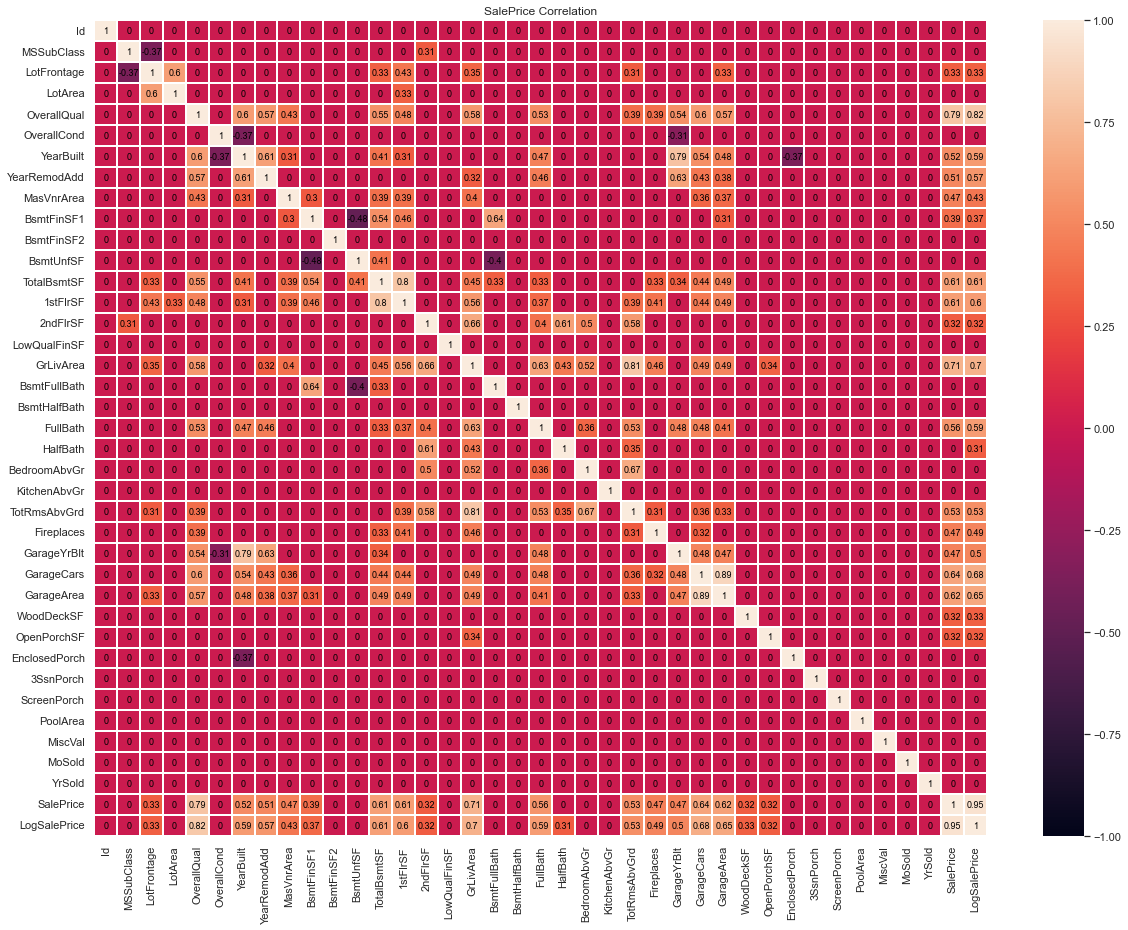

In [41]:
# Heatmap for all the remaining numerical data including the taget 'SalePrice'
# Define the heatmap parameters
pd.options.display.float_format = "{:,.2f}".format

# Define correlation matrix
corr_matrix = df[num_feat].corr()

# Replace correlation < |0.3| by 0 for a better visibility
corr_matrix[(corr_matrix < 0.3) & (corr_matrix > -0.3)] = 0

# plot the heatmap
sns.heatmap(corr_matrix, vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot_kws={"size": 9, "color": "black"},annot=True)
plt.title("SalePrice Correlation")

### We can see that, The overall quality of the house and Ground living Area has 0.79 and 0.74 correlation with the SalePrice of the house, followed by Garagecars with 0.64 correlation.

In [42]:
# Lets visualize individually 
# Gives the most correlated features with House Saleprice
corr =df.corr()["SalePrice"].sort_values(ascending = False)[2:8] ## selecting cols other than Saleprice, LogPrice
corr

OverallQual   0.79
GrLivArea     0.71
ExterQual     0.68
KitchenQual   0.66
GarageCars    0.64
GarageArea    0.62
Name: SalePrice, dtype: float64

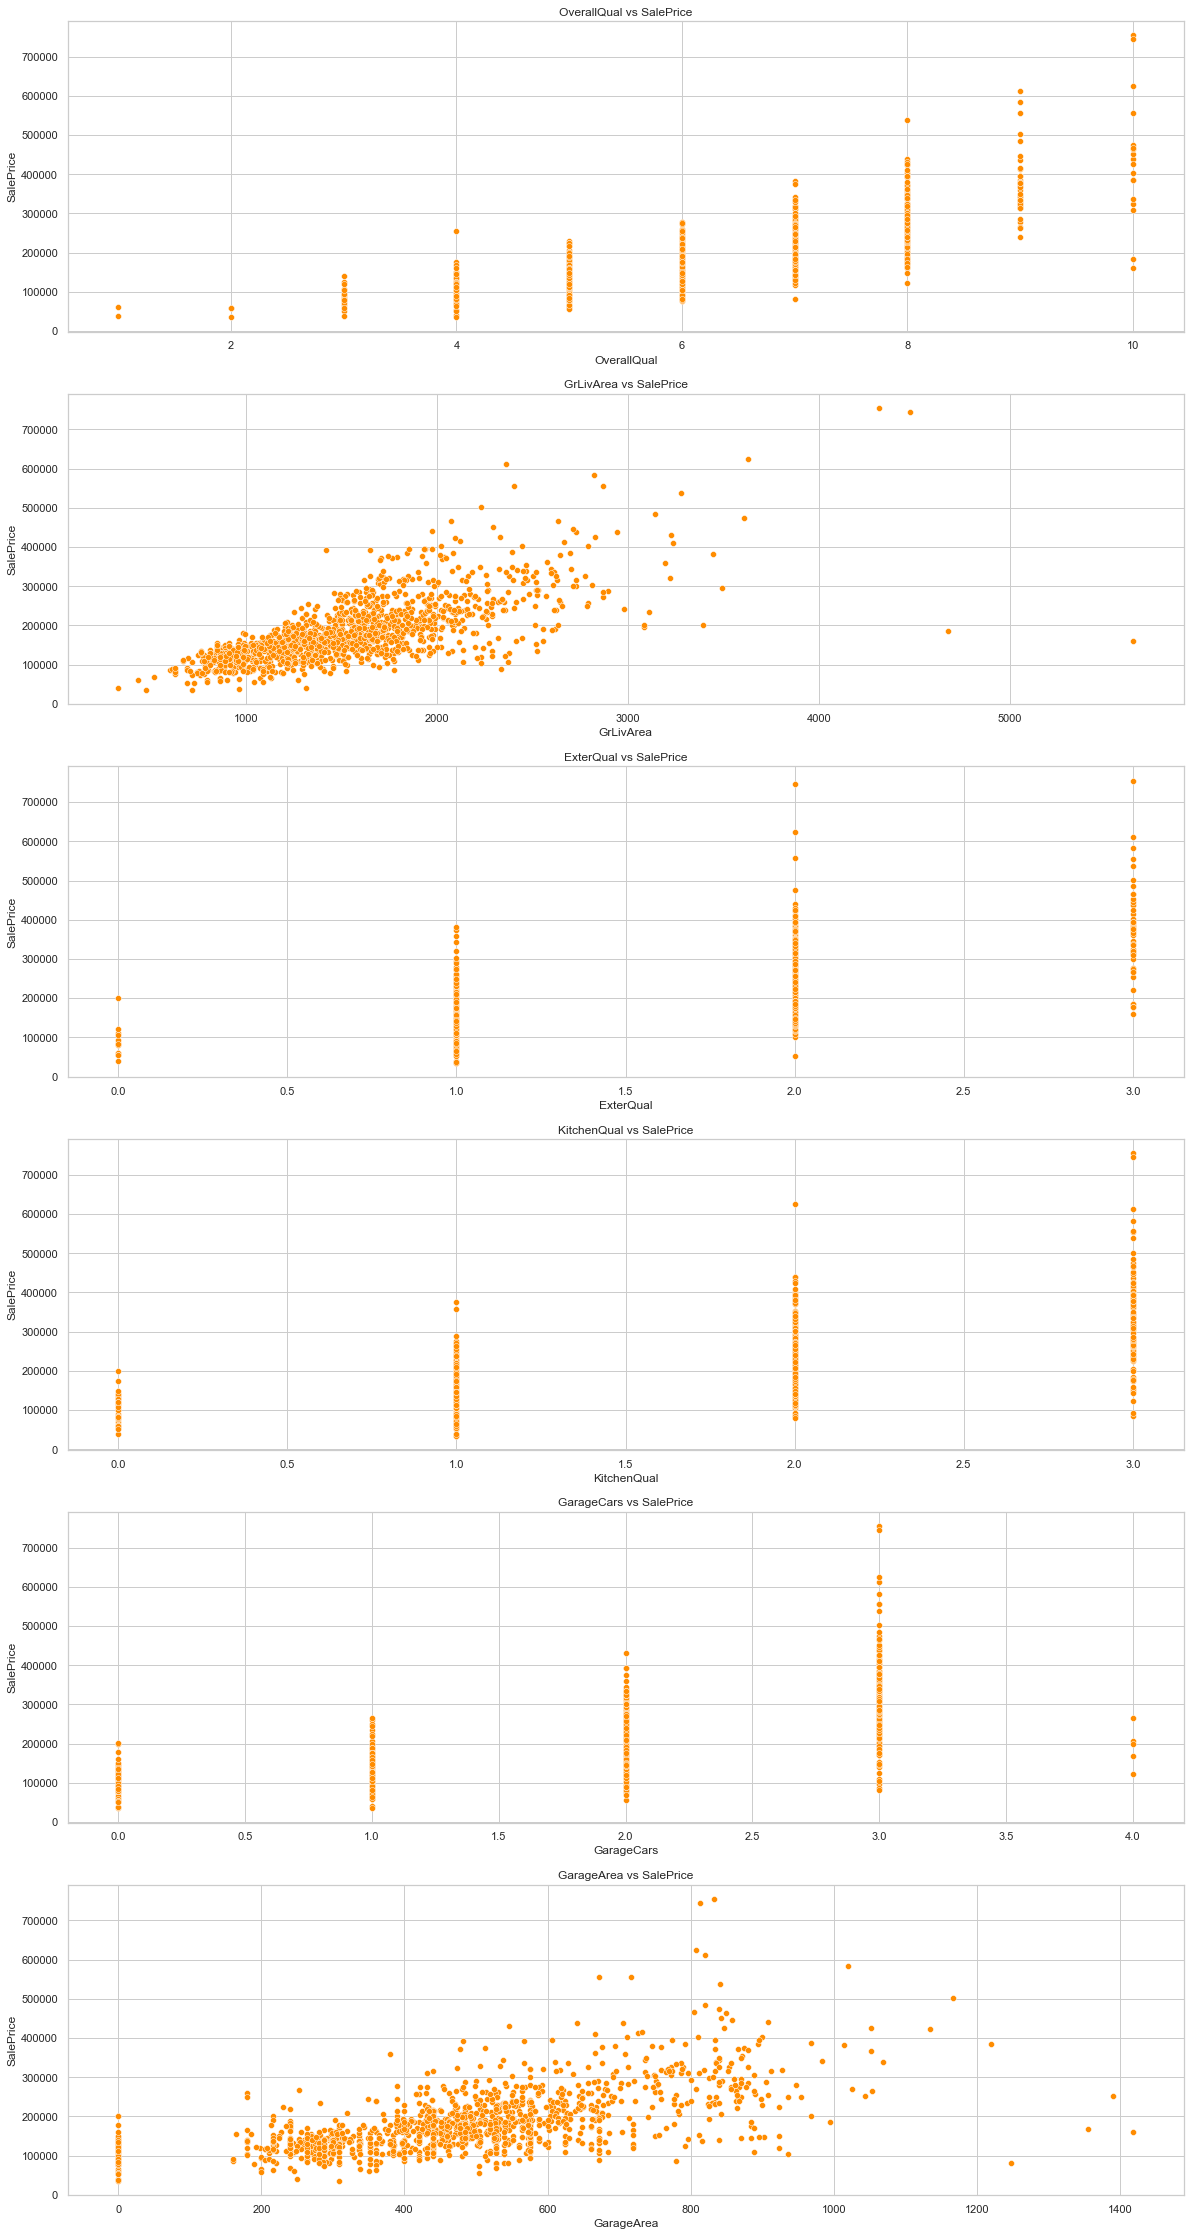

In [43]:
# Plot the most correlated features against the SalePrice to see the relationship visually
f,ax = plt.subplots(nrows = 6,ncols = 1, figsize = (20,40))
for i,col in enumerate(corr.index):    
    sns.scatterplot(x = col, y = "SalePrice", data = df, ax = ax[i], color = 'darkorange')
    ax[i].set_title(f'{col} vs SalePrice')

We can see the features above are quite linear to the Sale Price suggesting positive correlation.

### Question 2: What year were most of the houses built (Top 10), and does the year built say anything regarding the sale price?

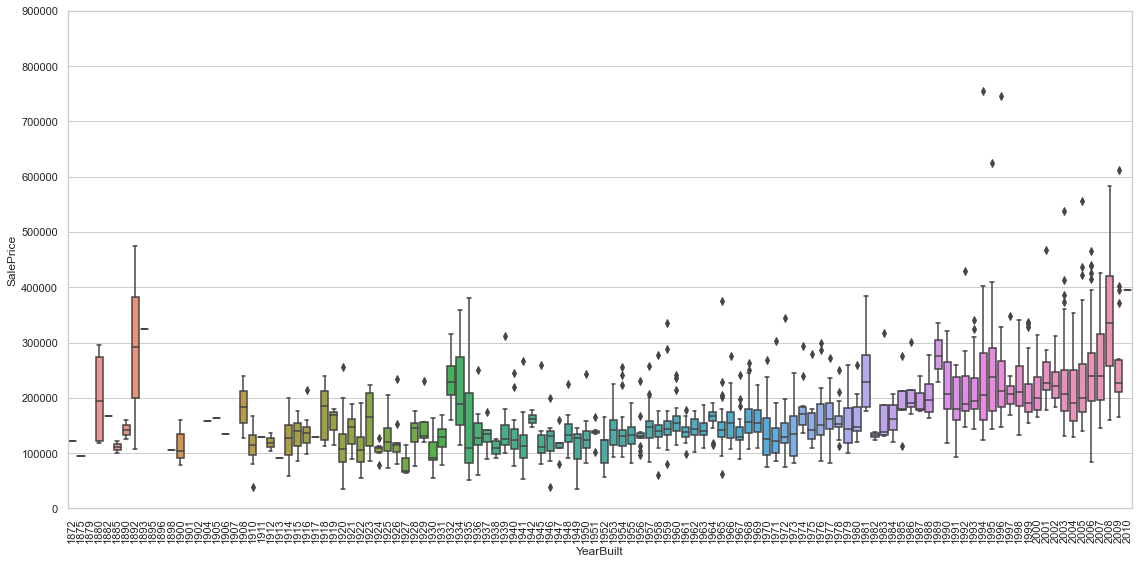

In [45]:
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x="YearBuilt", y="SalePrice", data=df,)
fig.axis(ymin=0, ymax=900000);
plt.xticks(rotation=90);
plt.tight_layout()

Text(0.5, 1.0, 'Year Built')

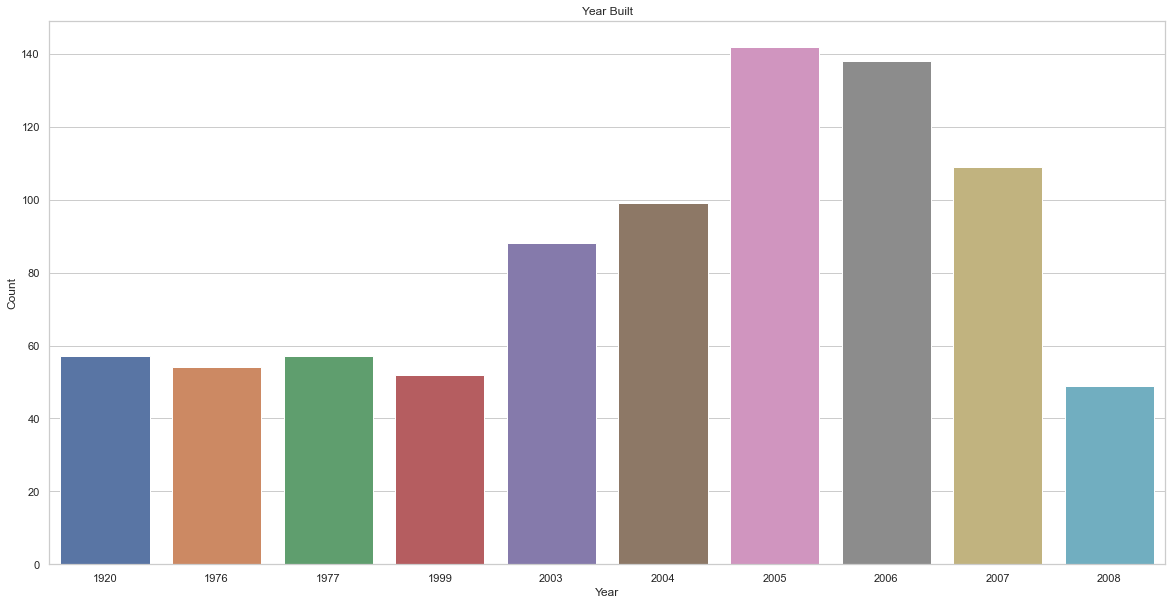

In [46]:
yr_built = pd.DataFrame({"Count":df["YearBuilt"].value_counts()[:10]}).reset_index()
yr_built.rename(columns={'index':'Year'},inplace=True)
plt.figure(figsize = (20,10))
sns.barplot(x = 'Year', y = "Count", data = yr_built)
plt.title("Year Built")

In [47]:
#### As a side question, lets see if there is a huge difference in sale price based on different months

<AxesSubplot:xlabel='MoSold'>

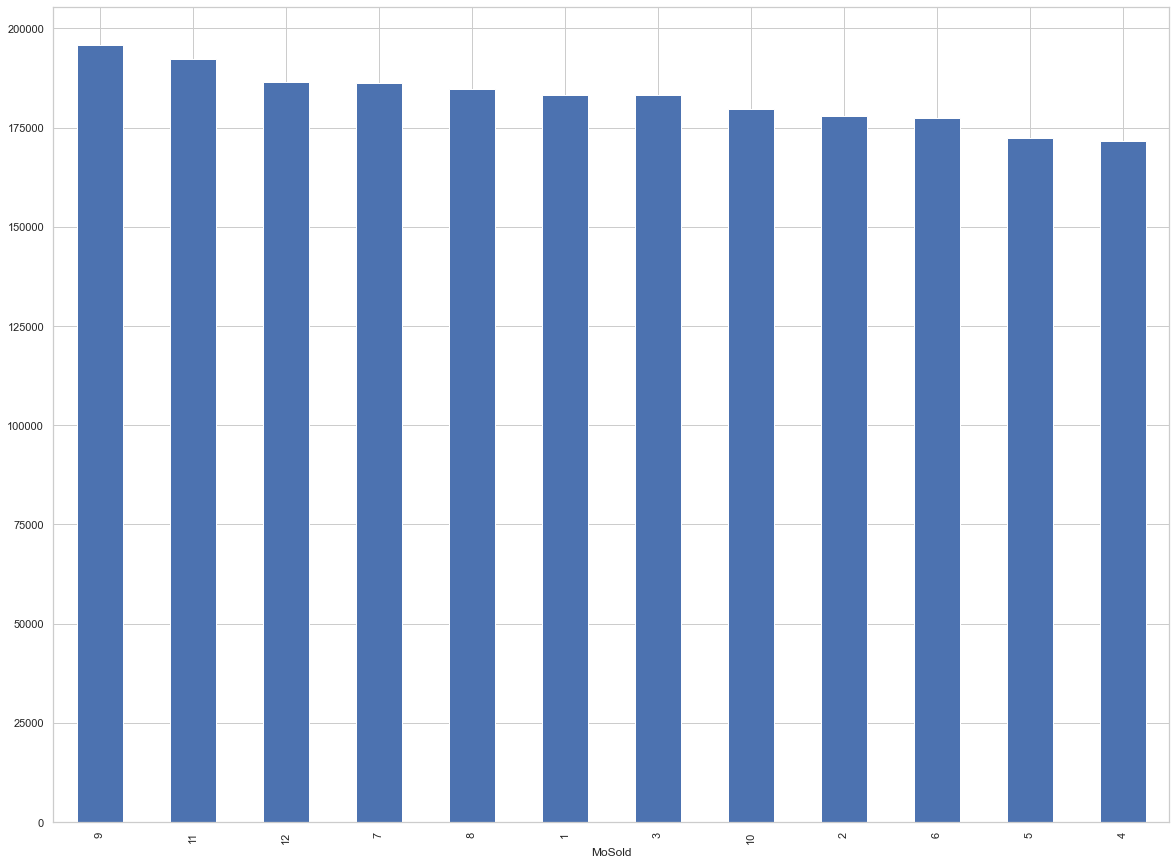

In [48]:
df.groupby("MoSold").mean()["SalePrice"].sort_values(ascending = False).plot(kind = 'bar')

### Most of the houses were built in the year 2005, 2006. On average the houses built after 1980 have higher Saleprice. There is also no significance difference in terms of average saleprice based on month. September taking the lead.

### Question 3: Are the features in the dataset good enough to predict house Sale Prices?

## Predict the test dataset

In [94]:
## Predict the test data and inverse log
y_pred = mod_gb.predict(X_test)
y_pred_inv = 10 ** y_pred
y_pred_inv # These are the predicted values for the test data

array([125949.1703326 , 153099.7024292 , 185686.76016013, ...,
       160267.04312333, 118776.8966367 , 249364.66600371])

It gave: RMSE : 0.0009382414154572565

Yes, the features in the Kaggle house sale price regression dataset are good enough to predict the sale price of houses. By using a gradient booster model, which is a powerful machine learning algorithm, it is likely that I was able to achieve a high level of accuracy in the predictions. This suggests that the features included in the dataset are relevant and useful in determining the sale price of houses.

### Conclusion

This house sale price regression analysis was a comprehensive examination of the factors that influence the sale price of houses. The dataset provided by Kaggle gave us a unique opportunity to use machine learning techniques to make predictions about the sale price. Our analysis showed that the model was able to accurately predict the sale price of houses based on various factors.

The most significant findings of this analysis were the correlations between the sale price and the overall quality of the house, the size of the ground living area, and the presence of a car garage. These insights provide valuable information for anyone involved in the real estate industry, as they help to identify key factors that can impact the value of a property. In addition, this information could be used to make more informed decisions when buying or investing in real estate.

Furthermore, this analysis highlights the importance of data analysis and machine learning in the real estate industry. By leveraging these techniques, we can gain a deeper understanding of the factors that impact the sale price of properties, which can ultimately help to make better investment decisions. Overall, this analysis was a valuable learning experience, and we hope that it will encourage others to continue exploring the potential of data and machine learning in the real estate industry.